In [2]:
!pip install jovian -q

In [3]:
import jovian

<IPython.core.display.Javascript object>

In [1]:
import tensorflow as tf
# get device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print(f'Found gpu as {device_name}')
else:
  raise SystemError('GPU device not found')

SystemError: GPU device not found

In [4]:
import torch

# check if gpu available 
if torch.cuda.is_available():
  # set pytorch to use gpu
  device = torch.device("cuda")
  print(f" There are {torch.cuda.device_count()} GPU(s) available. We will use GPU {torch.cuda.get_device_name(0)}." )
else:
  print("No GPU available. Using CPU instead.")
  device = torch.device('cpu')

Np GPU available. Using CPU instead.


In [6]:
# installing huggingface transformer library
!pip install transformers -q

## Download wine reviews data from kaggle

In [9]:
import pandas as pd
df = pd.read_csv('winemag-data-130k-v2.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [36]:
df['description'][10]

'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.'

In [37]:
df['points'] = df['points'] - 80 # setting points from 0 to 21

In [38]:
train_df = df[['description','title', 'points']]

In [39]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load bert tokenizer
print('Load DistilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case = True)

Load DistilBERT tokenizer...


In [40]:
# Let us take a look at the first description and tokenize it
text = train_df.iloc[0].description
# Run tokenizer and count number of tokens
tokens = tokenizer.tokenize(text)
print(f'First description contains {len(tokens)} wordpiece tokens.')

First description contains 39 wordpiece tokens.


### Let us now analyze how the description length is distributed

In [41]:
import numpy as np
#tokenize all the descriptions and map tokens to their word IDs

input_ids = []

# Record length of each sequence (truncate to 512 -> BERT limit of for input sequence)
lengths = []

for des in train_df.description:
  if (len(input_ids) % 30000 == 0) and len(input_ids)!=0:
    print(f'Completed reading {len(input_ids)} lines.')

  # tokenizer.enode does
    # Tokenize
    # Prepend [CLS] token
    # Append [SEP] token
    # Map token to their IDs

  encoded_sent = tokenizer.encode(
      des, # description
      add_special_tokens = True, #add [CLS] and [SEP]

  )
  # add encoded text to list
  input_ids.append(encoded_sent)
  # record the truncated length
  lengths.append(len(encoded_sent))

print('Done')

Completed reading 30000 lines.
Completed reading 60000 lines.
Completed reading 90000 lines.
Completed reading 120000 lines.
Done


In [42]:
# Get labels from train_df 
labels = train_df.points.to_numpy().astype(int)

In [43]:
print(f'Minimum length of tokens is {min(lengths)}.')
print(f'Maximum length of tokens is {max(lengths)}.')
print(f'Median length of tokens is {np.median(lengths)}.')

Minimum length of tokens is 7.
Maximum length of tokens is 194.
Median length of tokens is 57.0.


### Lets plot this distribution using matplotlib

In [44]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style = 'darkgrid', font_scale = 1.5)
plt.rcParams['figure.figsize'] = (10,5)

/var/folders/yv/z1dch3dj5wx3188lknqcwcc00000gn/T/ipykernel_29563/88835753.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths);


Text(0, 0.5, '# of sentences')

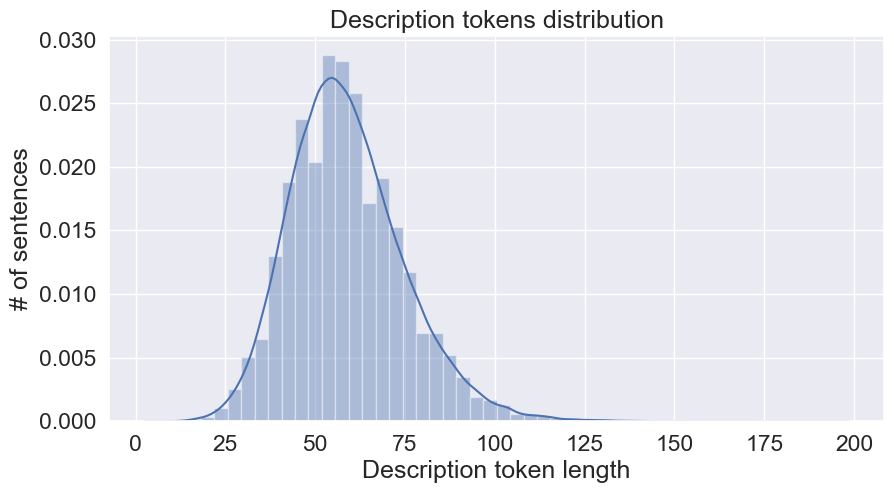

In [45]:
sns.distplot(lengths);
plt.title('Description tokens distribution');
plt.xlabel('Description token length')
plt.ylabel('# of sentences')

Lengths of all the tokens are less than 512 which is standerd limit for BERT. Hence we can use our tokens without dropping any of the data samples.

In [46]:
# PAD the tokens for future use
from keras.preprocessing.sequence import pad_sequences
# Most of sequences have token length smaller than 128
MAX_LEN = 128
print(f'\nPadding and truncating sentences to {MAX_LEN} values...')
print(f'\nPadding token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}')
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long',
                          value=tokenizer.pad_token_id, truncating = 'post', padding = 'post')

print('Done')


Padding and truncating sentences to 128 values...

Padding token: [PAD], ID: 0
Done


In [47]:
# create attention mask
attention_masks = []
for sent in input_ids:
  # if token id == 0 then its padding so set mask to 0
  # else its a real token and hence set mask == 1
  attn_mask = [int(token_id > 0) for token_id in sent]
  attention_masks.append(attn_mask)

### performing train and validation split for sentences and attention masks

In [48]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 1234, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,random_state = 1234, test_size = 0.1)

In [49]:
# converting all the numpy arrays to pytorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [50]:
# Using pytorch dataloader class to help with training
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
# train data loader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
# test data loader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

## Bert fine tuning by using Bert for squence classification using huggingface library

In [51]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', # use 12 layer base Distil-BERT with uncased vocab
    num_labels = 21, # Linear regression unique points
    output_attentions = False, # Do not return attention weights
    output_hidden_states = False )# do not retun all hidden states

model.cuda()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AssertionError: Torch not compiled with CUDA enabled

In [52]:
optimizer = AdamW(model.parameters(), lr = 2e-4, eps = 1e-8)

/Users/khadarty/miniconda3/envs/tfenv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup
# number of training epochs
epochs = 4
# number of training steps
total_steps = len(train_dataloader)* epochs
# learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# helper functions 
import time
import datetime
def flat_accuracy(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(preds_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
  '''
  retunr time in hh:mm:ss from seconds
  '''
  elapsed_round = int(round(elapsed))
  return str(datetime.timedelta(seconds = elapsed_round))

## Following cell takes upto 2 hr depending on dataset size and GPU variety (Do not run unless really necessary)

In [ ]:
import random
import numpy as np
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 1234

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids,
                           attention_mask = b_input_mask,
                           labels = b_labels)
#         loss, logits = output.loss, output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss, logits = model(b_input_ids,
                           attention_mask = b_input_mask,
                           labels = b_labels)
#         loss, logits = output.loss, output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    torch.save(model, (f"./model/model_{epoch_i}.pth"))
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], '-', label="Training")
plt.plot(df_stats['Valid. Loss'], '--', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Saving model and training arguments

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(model, output_dir+"/model.pth")

In [ ]:
jovian.commit(artifacts = ['./model/model.pth'],project = 'semantic_similarity_wine')

In [ ]:
import torch
from keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
# Load bert tokenizer
print('Load DistilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case = True)
# Loading model and setting output hidden states flag to true
print('Load DistilBERT model...')
model = DistilBertForSequenceClassification.from_pretrained('../input/distilbertmodel-trained-wine-reviews', output_hidden_states = True)
model.cuda()
def text_to_embedding(tokenizer,model, input_text):
    # Step 1 = Tokenization
    MAX_LEN = 128 #Max token length
    input_ids = tokenizer.encode(
      input_text, # description
      add_special_tokens = True, #add [CLS] and [SEP]
        max_length = MAX_LEN,
        truncation=True
  )
    result = pad_sequences([input_ids], maxlen=MAX_LEN, dtype='long',
                          value=tokenizer.pad_token_id, truncating = 'post', padding = 'post')
    input_ids = result[0]
    attn_mask = [int(token_id > 0) for token_id in input_ids]
    
    # to tensor
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)
    
    # Adding extra dimension for processing
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)
    
    # to GPU
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    # step 2 evaluaring text on DistilBERT model
    model.eval()
    # No gradient tracking mode
    with torch.no_grad():
        _ , encoded_layer = model(input_ids = input_ids,attention_mask = attn_mask)
         
        
    layer_i = 6 # last layer for DistilBERT
    batch_i = 0 # Only One input in the batch
    token_i = 0 # Get token for the [CLS] 
    # Get sentece emedding 
    vec = encoded_layer[layer_i][batch_i][token_i]
    vec = vec.detach().cpu().numpy() # move to cpu and convert to numpy
    norm = np.linalg.norm(vec) # for normalizing the vector
    return vec/norm
    
    

In [ ]:
text = train_df.iloc[0].description
vec = text_to_embedding(tokenizer, model, text)
print(vec.shape)

## Following cell uses trained model and uses outputs of last hidden layer to get sentence embeddings for all the reviews (pretrained embeddings are already in data do not run unless model is trained on new data. Takes about 18 minutes)

In [ ]:
# Converting all Texts to vectors
import time
# Setting initial time
t0 = time.time()

embeddings = []
# Number of comments
num_text = len(train_df.description)
for text in train_df.description:
    if (len(embeddings) % 2000 == 0) and len(embeddings)!=0:
        elapsed = format_time(time.time() - t0)
        print(f'Completed reading {len(embeddings)} lines. Took time {elapsed}.')
        
    vec = text_to_embedding(tokenizer, model, text)
    embeddings.append(vec)
    
    

In [ ]:
import numpy as np
vecs = np.vstack(embeddings)
print(vecs.shape)

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.save("./model/Text_embeddings.npy",vecs)

In [29]:
import numpy as np
# Loading previously saved numpy embeddings
embeddings = np.load('../input/distilbertmodel-trained-wine-reviews/Text_embeddings.npy')
# Enter qualities of wine that you would like to get recommendations for
text_to_search = """Vintage, old, red, pinot, white, cherry, fruit"""
print("Description to look for -", text_to_search)
vec = text_to_embedding(tokenizer, model, text_to_search)
result = np.matmul(embeddings, vec)
top_5_row_nums = result.argsort()[-5:][::-1]

Description to look for - Vintage, old, red, pinot, white, cherry, fruit


In [30]:
print("====== Top 5 related Wines with reviews ======")
for row in top_5_row_nums:
    print('Name - ', df.iloc[row].title,'\n', '')
    print('Review - ' , train_df.iloc[row].description,'\n')
    

====== Top 5 related Wines with reviews ======
Name -  Cedar Mountain 2009 Reserve Petite Sirah (Livermore Valley) 
 
Review -  Generous in white pepper, particularly on the nose, this Petite has tight, puckering tannins pleading for more time in the bottle. Soft flavors lean to the leathery blackberry and licorice side of things. 

Name -  Novy 2013 Four Mile Creek White (North Coast) 
 
Review -  Full in flavor and body, this sturdy wine based on Viognier, Sauvignon Blanc and Pinot Gris with a dash of Chardonnay has crisp acidity to keep it lively. It smells like pears and honeydew melon and tastes dry but generous and a little buttery, and finishes clean. 

Name -  Zepaltas 2008 Nunes Vineyard Pinot Noir (Russian River Valley) 
 
Review -  Sharp and candied, with Lifesaver sweet-and-sour cherries and cola softened with smoky wood notes. The tannins are sandpapery and firm. Drink now with rich beef and lamb. 

Name -  Château du Carrubier 2014 Red (Côtes de Provence) 
 
Review -  Thi